# Practice Session 05: PageRank

*Introduction to Network Science* (2025/26), UPF

We will compute PageRank on a graph that represents the web of UK around 2007. Each node is a host, and there is a link between two hosts if there is a web page in one of them pointing to a web page in the other one. This network is weighted: the weight is the number of pages that point from one host to the other one.

The collection we will use, [WEBSPAM-UK2007](http://chato.cl/webspam/datasets/uk2007/), has been used in multiple studies on the effect of web spam. Feel free to decompress these files to inspect them, **but your code must read only these files in compressed form**:

* ``webspam_uk2007-nodes.csv.gz`` contains (``nodeid``, ``hostname``, ``label``) records
* ``webspam_uk2007-edges.csv.gz`` contains (``source``, ``destination``, ``weight``) records

Your task is to compute PageRank twice: first considering all the links, and then ignoring links from or to a known spam host.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 1. Read host names

Read the names of the nodes and the labels. For this, you can use [`csv.DictReader()`](https://docs.python.org/3/library/csv.html#csv.DictReader). Suppose ``FILENAME`` points to a file with the following contents:

```
a,b,c,d
1,2,3,4
5,6,7,8
```

The following code:

```python
with gzip.open(FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        print(record["b"])
```

Prints:

```
2
6
```

Remember in the `INPUT_NODES_FILENAME` each record contains ``nodeid``, ``hostname``, and ``label``.

Create a nested dictionary `hosts`, which has `hostid`s as keys and host data dictionaries as values: with a "name" field to hold the `hostname` and "label" field to hold `label`. That is, hosts will have a structure like:

```plain
{
    id_of_host_1: {
        "name": host_1_name,
        "label" : host_1_label
    },
    id_of_host_2: {
        ...
    },
    ...
}
```

Additionally, record a name to id mapping into a dictionary `name2id`. They keys (`nodeid`s) in both dictionaries should be converted to integers using ``int()``.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
# Imports — leave as is

import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Input file locations — you might need to change these depending on where you stored your files

INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

<font size="+1" color="red">Replace this cell with your code to read the ``INPUT_NODES_FILENAME`` file into `hosts` and `name2id`.</font>

In [4]:
hosts = {}
name2id = {}

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        nodeid = int(row["nodeid"])
        hostname = row["hostname"]
        label = row["label"]
        
        hosts[nodeid] = {
            "name": hostname,
            "label": label
        }
        name2id[hostname] = nodeid

Verify that you read correctly the file. The following will test two known hosts: *873* should be the BBC (a non-spam site) and *105715* should be a spam website that used to sell mobile phones.

If you get a `KeyError` error, most likely you did not convert the ids to integers.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
# Leave as-is

print("Number of hosts: %s" % len(hosts))
print("%s: %s" % (hosts[873]['name'], hosts[873]['label']))
print("%s: %s" % (hosts[105715]['name'], hosts[105715]['label']))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


Next, print how many hosts and what percentage have label `spam`, `nonspam`, and `unlabeled`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the number and percentage of the hosts are spam, nonspam, and unlabeled. The latter should be the large majority. Format the number with thousand separators and the percentage with one decimal (e.g., ``unlabeled: 108,476 (94.7%)``).</font>

In [7]:

spam_count = 0
nonspam_count = 0
unlabeled_count = 0


for nodeid in hosts:
    label = hosts[nodeid]["label"]
    if label == "spam":
        spam_count += 1
    elif label == "nonspam":
        nonspam_count += 1
    elif label == "unlabeled":
        unlabeled_count += 1

total_hosts = len(hosts)

spam_pct = (spam_count / total_hosts) * 100
nonspam_pct = (nonspam_count / total_hosts) * 100
unlabeled_pct = (unlabeled_count / total_hosts) * 100

print(f"spam: {spam_count:,} ({spam_pct:.1f}%)")
print(f"nonspam: {nonspam_count:,} ({nonspam_pct:.1f}%)")
print(f"unlabeled: {unlabeled_count:,} ({unlabeled_pct:.1f}%)")


spam: 344 (0.3%)
nonspam: 5,709 (5.0%)
unlabeled: 108,476 (94.7%)


Now let's explore a small part of the graph. For this, you will need to open the file `INPUT_EDGES_FILENAME` which contains columns `source`, `destination`, and `weight` indicating that some pages in host id `source` point to pages in host id `destination`. The number of such pages is the `weight`.

The graph is too large so we will focus on three categories that tend to be heavily spammed: shopping, financial services and adult content. We will filter by the following keywords:

```python
    spammywords = ['credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl', 'mistress', 'important', 'attention']
```

Now, create a directed graph (a NetworkX `DiGraph()`) containing all the edges that fulfil ***all three* of the following conditions**:

1. The source contains one of the `spammywords` **or** the destination contains one of the `spammywords` (you can check substring membership easily with the [`in` operator](https://mimo.org/glossary/python/in-operator))
1. The source is labeled as either `spam` or `nonspam`
1. The destination is labeled as either `spam` or `nonspam`

Your graph should have nodes that are hostnames, so whenever you find such an edge in the input file, you should do:

```python
    g.add_edge(hosts[source]['name'], hosts[destination]['name'])
```

Print the number of nodes in the resulting graph, it should be less than 200.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to load a subgraph of the input graph, as described above.</font>

In [8]:
spammywords = [
    'credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury',
    'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort',
    'xx', 'girl', 'mistress', 'important', 'attention'
]

g = nx.DiGraph()

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    
    for row in reader:
        src_id = int(row["source"])
        dst_id = int(row["destination"])

        # Get source and destination hostnames and labels
        src_name = hosts[src_id]["name"]
        dst_name = hosts[dst_id]["name"]
        src_label = hosts[src_id]["label"]
        dst_label = hosts[dst_id]["label"]

        # Condition 1: source or destination name contains a spammy word
        found_spammy = False
        for w in spammywords:
            if w in src_name or w in dst_name:
                found_spammy = True
                break
        
        # Condition 2 & 3: both source and destination labeled spam or nonspam
        if found_spammy and src_label in ["spam", "nonspam"] and dst_label in ["spam", "nonspam"]:
            g.add_edge(src_name, dst_name)

print("Number of nodes in subgraph:", g.number_of_nodes())
print("Number of edges in subgraph:", g.number_of_edges())

Number of nodes in subgraph: 172
Number of edges in subgraph: 155


The following code displays this subgraph. You can modify it if you wish, as long as the output is readable.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

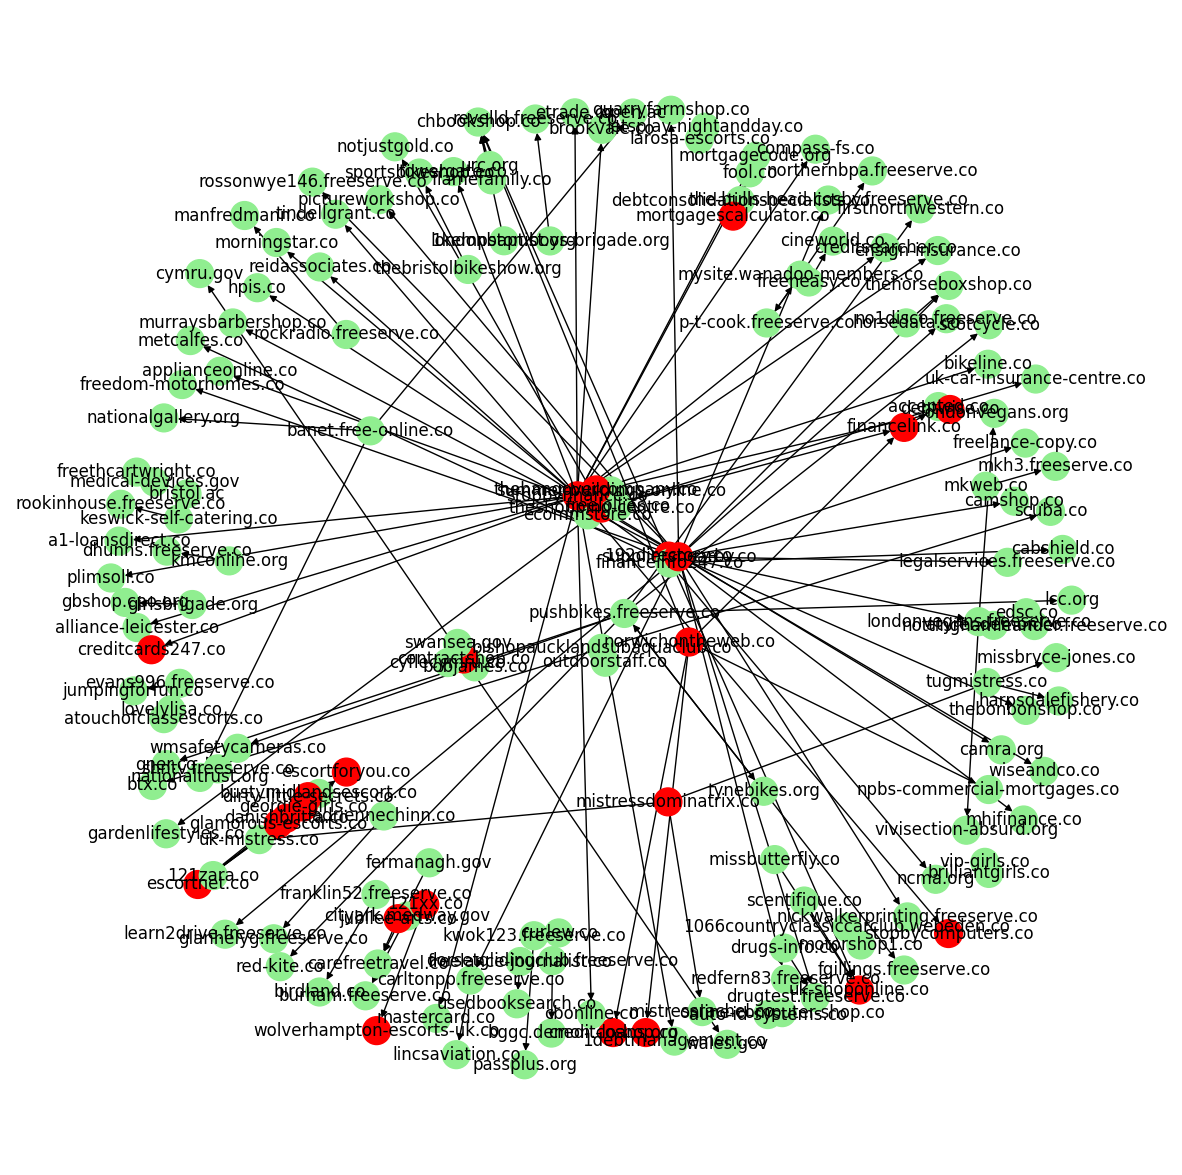

In [9]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if hosts[name2id[hostname]]['label'] == 'spam':
        colors.append('red')
    elif hosts[name2id[hostname]]['label'] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(15, 15))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

<font size="+1" color="red">Replace this cell with a brief commentary on what you see in the plot above.</font>

In the graph above, we can see a bunch of websites connected by links. The red nodes are spam sites and the green ones are non-spam. Most of the spam nodes seem to cluster together and point to each other, which makes sense since spam sites usually try to boost each other’s ranking. The non-spam sites are more spread out and have fewer connections to spam ones. Overall, it looks like spam sites form tight groups while the non-spam ones are more separate.

Let's use this example as a brief exercise to cement the theory, in particular the difference between conditional and joint probabilities and how these apply to edges on a network.

You should calculate the following probabilities (keep in mind edges are directed):
* The (marginal) probability of observing and edge A->B where A is a spam node.
* The (joint) probability of observing a spam->nonspam edge in the network.
* The (conditional) probability of observing a spam->nonspam edge, *given that* we start from a spam node.

Write some code to calculate these probabilities. It should take no more than a few lines of code. Think simple!

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to calculate the probabilities described above. Then briefly comment, do these values make sense to you?</font>

In [10]:
total_edges = g.number_of_edges()
spam_source_edges = 0
spam_to_nonspam_edges = 0

for (u, v) in g.edges():
    uid = name2id.get(u)
    vid = name2id.get(v)
    if uid is None or vid is None:
        continue
    u_label = hosts[uid]["label"]
    v_label = hosts[vid]["label"]

    if u_label == "spam":
        spam_source_edges += 1
        if v_label == "nonspam":
            spam_to_nonspam_edges += 1

if total_edges > 0:
    p_source_spam = spam_source_edges / total_edges
    p_spam_to_nonspam = spam_to_nonspam_edges / total_edges
else:
    p_source_spam = 0.0
    p_spam_to_nonspam = 0.0

if spam_source_edges > 0:
    p_spam_to_nonspam_given_spam = spam_to_nonspam_edges / spam_source_edges
else:
    p_spam_to_nonspam_given_spam = 0.0

print(f"P(source is spam): {p_source_spam:.4f}")
print(f"P(spam -> nonspam): {p_spam_to_nonspam:.4f}")
print(f"P(spam -> nonspam | source is spam): {p_spam_to_nonspam_given_spam:.4f}")


P(source is spam): 0.4968
P(spam -> nonspam): 0.3806
P(spam -> nonspam | source is spam): 0.7662


# 2. Compute the degree of each node

Compute the **out-degree** of each node and store it in a dictionary `id2degree`. (Remember we need this for the PageRank algorithm.) 

Do this while reading the edges file, without storing the graph in main memory. Remember that this file contains ``source``, ``destination``, ``weight`` records.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [11]:
# Leave this code as-is

# Initialize id2degree dict
id2degree = {}
N = len(hosts)
for nodeid in range(N):
    id2degree[nodeid] = 0

<font size="+1" color="red">Replace this cell with your code to read the degrees of nodes into `id2degree`.</font>

In [19]:
neighbors = {}

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        s = int(row["source"])
        d = int(row["destination"])
        if s not in neighbors:
            neighbors[s] = set()
        neighbors[s].add(d)

for nodeid in range(N):
    if nodeid in neighbors:
        id2degree[nodeid] = len(neighbors[nodeid])
    else:
        id2degree[nodeid] = 0


Verify that you are reading correctly the file. The following cell should print:

```plain
www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38
```

If you get a key not found error, most likely you did not convert the ids to integers or you did not initialize the id2degree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [20]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: degree {id2degree[nodeid]}")

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

Perform `ITERATIONS=25` iterations with `ALPHA=0.91`. In each iteration, you will read the file of the graph, **without loading the entire graph in memory**. This means each iteration involves opening (and implicitly, closing) the edges file.

Your code should do the following:

* At the beginning, initialize the vector `pagerank` as a vector of 1/N and the vector `pagerank_aux` as a vector of 0s.
* For `iterations` iterations:
   * Read the graph and for every link from *source* to *destination*:
      * Add to `pagerank_aux[destination]` the value `pagerank[source]/degree`, where `degree` is the out-degree of the source node (i.e, its number of out-links).
   * Set `pagerank` of every node to `alpha x pagerank_aux + (1.0-alpha) x (1.0/N)`.
   * Normalize the values of `pagerank` so they add up to 1.0
   * Compute and print `delta` as the sumation of the absolute changes in PageRank between this iteration and the previous one; this value should decrease from one iteration to the next
   * Set `pagerank_aux` to 0.0

Remember: do not keep the graph in memory, because that will limit the size of the graphs your code can handle. At every iteration you must read the file again. You can use the following template:

```python
for iteration in range(ITERATIONS):
    print(f"Iteration {iteration+1} of {ITERATIONS}")
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        ...

```

After each iteration, print the `delta` with 4 decimals. This sum should be, in general, decreasing.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this cell as-is

ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

<font size="+1" color="red">Replace this cell with your code to compute PageRank.</font>

In [22]:
ITERATIONS = 25
ALPHA = 0.91

N = len(hosts)
pagerank = [1.0 / N] * N
pagerank_aux = [0.0] * N

for iteration in range(ITERATIONS):
    print(f"Iteration {iteration+1} of {ITERATIONS}")

    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file)
        for row in reader:
            s = int(row["source"])
            d = int(row["destination"])
            deg = id2degree[s]
            if deg > 0:
                pagerank_aux[d] += pagerank[s] / deg

    dangling_mass = 0.0
    for i in range(N):
        if id2degree[i] == 0:
            dangling_mass += pagerank[i]

    teleport = (1.0 - ALPHA) / N
    dm_contrib = ALPHA * (dangling_mass / N)

    new_pagerank = [0.0] * N
    for i in range(N):
        new_pagerank[i] = ALPHA * pagerank_aux[i] + dm_contrib + teleport

    ssum = 0.0
    for x in new_pagerank:
        ssum += x
    if ssum != 0.0:
        for i in range(N):
            new_pagerank[i] = new_pagerank[i] / ssum

    delta = 0.0
    for i in range(N):
        diff = new_pagerank[i] - pagerank[i]
        if diff < 0:
            diff = -diff
        delta += diff
    print(f"delta = {delta:.6e}")

    pagerank = new_pagerank
    for i in range(N):
        pagerank_aux[i] = 0.0


Iteration 1 of 25
delta = 6.971186e-01
Iteration 2 of 25
delta = 2.740359e-01
Iteration 3 of 25
delta = 1.303548e-01
Iteration 4 of 25
delta = 7.242294e-02
Iteration 5 of 25
delta = 4.347694e-02
Iteration 6 of 25
delta = 2.769320e-02
Iteration 7 of 25
delta = 1.821396e-02
Iteration 8 of 25
delta = 1.231272e-02
Iteration 9 of 25
delta = 8.527169e-03
Iteration 10 of 25
delta = 6.053783e-03
Iteration 11 of 25
delta = 4.408286e-03
Iteration 12 of 25
delta = 3.300836e-03
Iteration 13 of 25
delta = 2.552376e-03
Iteration 14 of 25
delta = 2.046644e-03
Iteration 15 of 25
delta = 1.712810e-03
Iteration 16 of 25
delta = 1.496014e-03
Iteration 17 of 25
delta = 1.333626e-03
Iteration 18 of 25
delta = 1.194952e-03
Iteration 19 of 25
delta = 1.072234e-03
Iteration 20 of 25
delta = 9.642342e-04
Iteration 21 of 25
delta = 8.671255e-04
Iteration 22 of 25
delta = 7.809412e-04
Iteration 23 of 25
delta = 7.032797e-04
Iteration 24 of 25
delta = 6.340457e-04
Iteration 25 of 25
delta = 5.715535e-04


# 4. Nodes with largest values of PageRank

Print the top 20 hosts by PageRank, including the host name, and the PageRank value with 6 decimals.

You can use the `enumerate()` function which converts a list `[a, b, c]` into `[(0,a), (1,b), (2,c)]` and then `sort()` as follows. Suppose ``score`` contains ``[0.2, 0.7, 0.4]``:

```python
hosts_by_score = sorted(enumerate(score), key=lambda x: x[1], reverse=True)
```

Will return the list `[(1,0.7), (2,0.4), (0,0.2)]`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 20 hosts having the largest PageRank. Print the host `name`, `label`, and score with 6 decimals. Write a function because we will need to do this again.</font>

In [23]:
id_score_list = list(enumerate(pagerank))

id_score_list.sort(key=lambda x: x[1], reverse=True)

top20 = id_score_list[:20]


print("Top 20 hosts by PageRank:\n")
for rank, (nodeid, score) in enumerate(top20, start=1):
    name = hosts[nodeid]["name"]
    label = hosts[nodeid]["label"]
    print(f"{rank:2d}. {name:40s}  {label:8s}  {score:.6f}")

Top 20 hosts by PageRank:

 1. www.opsi.gov.uk                           unlabeled  0.004275
 2. www.adobe.co.uk                           unlabeled  0.003360
 3. www.ico.gov.uk                            unlabeled  0.002653
 4. www.dti.gov.uk                            unlabeled  0.002355
 5. www.defra.gov.uk                          unlabeled  0.002331
 6. www.direct.gov.uk                         unlabeled  0.001919
 7. news.bbc.co.uk                            unlabeled  0.001882
 8. www.dfes.gov.uk                           unlabeled  0.001843
 9. www.communities.gov.uk                    unlabeled  0.001801
10. www.fsa.gov.uk                            unlabeled  0.001692
11. www.nationalrail.co.uk                    unlabeled  0.001647
12. www.dh.gov.uk                             unlabeled  0.001569
13. www.bbc.co.uk                             unlabeled  0.001536
14. www.hmso.gov.uk                           unlabeled  0.001521
15. www.hse.gov.uk                            unl

<font size="+1" color="red">
Replace this cell with a brief commentary indicating: 

1. Why do you think the top sites are those ones; and
2. What is the percentage of commercial, government, and educational sites you see among the top 20?

</font>

The top sites have the highest PageRank because they get linked to by many other pages, especially from well-known or popular websites. These pages act like hubs and attract more connections, which boosts their score.

Most of the top 20 are commercial (.com or .co.uk) sites, which makes sense since businesses usually have more links and visibility online. There are only a few government (.gov.uk) or educational (.ac.uk) sites, maybe around 10–15%, because those types of sites don’t have as many incoming links compared to big commercial ones.

# 5. Run non-spam PageRank

Now, write code and run non-spam PageRank. For this, simply ignore any link in which the source and the destination are known spam hosts.

You can query this with something like

```python
hosts[source]['label'] != "spam" and hosts[destination]['label'] != "spam"
```

For this, you first need to compute the "no-spam degree" of the nodes in a dictionary `id2nsdegree` ("ns" stands for **n**on-**s**pam), and use that in the PageRank algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to compute `id2nsdegree`.</font>

In [24]:
ns_neighbors = {}

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        s = int(row["source"])
        d = int(row["destination"])

        if hosts[s]["label"] != "spam" and hosts[d]["label"] != "spam":
            if s not in ns_neighbors:
                ns_neighbors[s] = set()
            ns_neighbors[s].add(d)

id2nsdegree = {}
for nodeid in range(len(hosts)):
    if nodeid in ns_neighbors:
        id2nsdegree[nodeid] = len(ns_neighbors[nodeid])
    else:
        id2nsdegree[nodeid] = 0

Verify that you are reading correctly the file. The following cell should print:

```plain
www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [25]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: normal degree {id2degree[nodeid]} nospam degree {id2nsdegree[nodeid]}")

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


<font size="+1" color="red">Replace this cell with code to compute `nspagerank` (non-spam PageRank).</font>

In [26]:
ITERATIONS = 25
ALPHA = 0.91

N = len(hosts)
nspagerank = [1.0 / N] * N
pagerank_aux = [0.0] * N

for it in range(ITERATIONS):
    print(f"Iteration {it+1} of {ITERATIONS}")

    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            s = int(row["source"])
            d = int(row["destination"])
            if hosts[s]["label"] == "spam" or hosts[d]["label"] == "spam":
                continue
            deg = id2nsdegree[s]
            if deg > 0:
                pagerank_aux[d] += nspagerank[s] / deg

    dangling_sum = sum(nspagerank[i] for i in range(N) if id2nsdegree[i] == 0)
    
    for i in range(N):
        nspagerank[i] = ALPHA * pagerank_aux[i] + (1 - ALPHA) / N + ALPHA * dangling_sum / N

    total = sum(nspagerank)
    nspagerank = [p / total for p in nspagerank]

    delta = sum(abs(pagerank_aux[i] - nspagerank[i]) for i in range(N))
    print(f"delta = {delta:.6e}")

    pagerank_aux = [0.0] * N


Iteration 1 of 25
delta = 4.603780e-01
Iteration 2 of 25
delta = 3.276388e-01
Iteration 3 of 25
delta = 2.938703e-01
Iteration 4 of 25
delta = 2.779803e-01
Iteration 5 of 25
delta = 2.718438e-01
Iteration 6 of 25
delta = 2.681222e-01
Iteration 7 of 25
delta = 2.664403e-01
Iteration 8 of 25
delta = 2.652212e-01
Iteration 9 of 25
delta = 2.646006e-01
Iteration 10 of 25
delta = 2.640922e-01
Iteration 11 of 25
delta = 2.638091e-01
Iteration 12 of 25
delta = 2.635511e-01
Iteration 13 of 25
delta = 2.633969e-01
Iteration 14 of 25
delta = 2.632458e-01
Iteration 15 of 25
delta = 2.631480e-01
Iteration 16 of 25
delta = 2.630497e-01
Iteration 17 of 25
delta = 2.629837e-01
Iteration 18 of 25
delta = 2.629139e-01
Iteration 19 of 25
delta = 2.628658e-01
Iteration 20 of 25
delta = 2.628148e-01
Iteration 21 of 25
delta = 2.627773e-01
Iteration 22 of 25
delta = 2.627387e-01
Iteration 23 of 25
delta = 2.627102e-01
Iteration 24 of 25
delta = 2.626796e-01
Iteration 25 of 25
delta = 2.626574e-01


<font size="+1" color="red">Replace this cell with code to print the 20 hosts having the largest no-spam PageRank scores. Print the host `name`, `label`, and score with 6 decimals.</font>

In [30]:
id_score_list = list(enumerate(nspagerank))
id_score_list.sort(key=lambda x: x[1], reverse=True)

top20_ns = id_score_list[:20]

print("Top 20 hosts by non-spam PageRank:\n")
for nodeid, score in top20_ns:
    name = hosts[nodeid]["name"]
    print(name)


Top 20 hosts by non-spam PageRank:

www.opsi.gov.uk
www.adobe.co.uk
www.ico.gov.uk
www.dti.gov.uk
www.defra.gov.uk
www.direct.gov.uk
news.bbc.co.uk
www.dfes.gov.uk
www.communities.gov.uk
www.fsa.gov.uk
www.nationalrail.co.uk
www.dh.gov.uk
www.bbc.co.uk
www.hmso.gov.uk
www.hse.gov.uk
www.fco.gov.uk
www.google.co.uk
www.homeoffice.gov.uk
www.nationaltrust.org.uk
www.dft.gov.uk


<font size="+1" color="red">Replace this cell with a brief commentary indicating if you see any differences between the non-spam PageRank scores of these hosts and their regular PageRank scores.</font>

The top non-spam PageRank sites are mostly the same big, popular pages as before, but a few spammy ones disappeared. This makes sense because now we’re ignoring all links connected to spam hosts, so the spam sites lose their influence. The non-spam sites, especially large commercial or well-connected domains, still stay at the top since they get a lot of real links from other trusted pages.

Overall, the non-spam PageRank values look a bit lower for most sites, but the ranking order among normal sites doesn’t change much.

# 6. Compute spam gain

Finally, compute the gain of every host as *(Normal PageRank) / (No spam PageRank)*.

Among the top 50 hosts you might find many "spam" (business that look ilegitimate or that tend to rely on spam such as gambling, pornography, counterfeits, and scams). You might also find "normal" sites (i.e., websites that look legitimate), because spammers also point to legitimate sites to disguise their actions.

For each of the top 50 hosts, print the following:

* The hostname
* Its label (spam/nonspam)
* Their gain *(Normal PageRank) / (No spam PageRank)* with two decimals (e.g., "3.22")
* Their PageRank in scientific notation with two significant digits (e.g., "5.8e-06")
* Their no-spam-PageRank in scientific notation with two significant digits (e.g., "5.8e-06")

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the top 50 hosts by spam gain.</font>

In [29]:
spam_gain = []

for i in range(len(hosts)):
    if nspagerank[i] > 0:
        gain = pagerank[i] / nspagerank[i]
    else:
        gain = 0
    spam_gain.append((i, gain))

spam_gain.sort(key=lambda x: x[1], reverse=True)
top50 = spam_gain[:50]

print("Top 50 hosts by spam gain:\n")
for nodeid, gain in top50:
    name = hosts[nodeid]["name"]
    print(name)


Top 50 hosts by spam gain:

www.escortnet.co.uk
www.missionfish.org.uk
www.statistics.006.free-counter.co.uk
www.into.demon.co.uk
www.uk-shoponline.co.uk
www.aili.co.uk
www.geordie-girls.co.uk
www.shop.co.uk
www.computerarts.co.uk
www.hertfordshiremobilediscos.co.uk
www.kompass.co.uk
www.jlc.me.uk
connect4fun.co.uk
www.markwarner.co.uk
www.theshopping-centre.co.uk
www.quality-site-finder.co.uk
www.mercurywd.co.uk
www.suppliersnearby.co.uk
www.eastwoodtoday.co.uk
www.ideas21.co.uk
danishbritta.co.uk
sport.uk-shoponline.co.uk
www.192directory.co.uk
www.myplaceabroad.co.uk
www.masterquote.co.uk
www.freestuffjunction.co.uk
www.dooyoo.co.uk
www.kinky-links.co.uk
cgi07.oneandone.co.uk
www.glucosamineforyou.co.uk
www.contractshop.co.uk
www.norwichontheweb.co.uk
scrapbookingcastle.co.uk
www.top-mobile-phones.co.uk
hosting3.123-reg.co.uk
www.e-crm.co.uk
www.pet-supermarket.co.uk
www.northern-electric.co.uk
www.riversanimalhousing.co.uk
www.links-directory.co.uk
www.classicjaguarhire.co.uk
phone

<font size="+1" color="red">Replace this cell with a brief explanation, in your own words, of what the spam gain means, what kind of websites have the most spam gain, and what are the effects of using non-spam PageRank.</font>

Spam gain shows how much a site’s rank grows from spam links. Spammy sites like gambling or adult pages usually have the highest gain. Using non-spam PageRank lowers their scores and keeps normal sites on top.

# Deliver (individually)

A `.zip` file containing:

* This notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>